### Callin Switzer
###

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import os
import csv
import time
from scipy import signal
import itertools as it
import sys
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import scipy.io
import glob
import itertools

# Neural net libs
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
print("TensorFlow successfully installed.")
if tf.test.is_built_with_cuda():
    print("The installed version of TensorFlow includes GPU support.")

print(sys.version, "\n")
print("last run on " + str(datetime.now()))

C:\Users\calli\Anaconda3\envs\tfcpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


TensorFlow successfully installed.
3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)] 

last run on 2018-08-31 10:10:02.185970


In [3]:
# data directory
dataDir = r"D:\Dropbox\dataAnalysisForOthers\MothMuscleLength\Data"

# figure directory
figDir = r"D:\Dropbox\dataAnalysisForOthers\MothMuscleLength\Figures" 
if not os.path.exists(figDir):
    os.makedirs(figDir)
    
# data output
dataOut = r"D:\Dropbox\dataAnalysisForOthers\MothMuscleLength\DataOut" 
if not os.path.exists(dataOut):
    os.makedirs(dataOut)

In [ ]:
# read in data
#"D:\Dropbox\dataAnalysisForOthers\MothMuscleLength\Data\emglength_8_28.csv"

In [ ]:
musLen = pd.read_csv(os.path.join(dataDir, "emglength_8_28.csv"))
musLen.drop(axis = 1, columns=musLen.columns[0], inplace=True)
print(musLen.shape)
#musLen["sec2"] = np.round(musLen.sec, decimals=4)
musLen.head(20)

In [ ]:
comF = musLen

In [ ]:
print(comF.shape)
comF.tail()

In [ ]:
sm = comF.iloc[0:25000, ].copy()


In [ ]:
#plt.plot(sm.timestamp, sm.EMG)
plt.plot(sm.sec, sm.EMG)
#plt.show()
plt.plot(sm.sec, sm.len + 1)

In [ ]:
from scipy.signal import savgol_filter
yhat = savgol_filter(sm.len + 1, 21, 3) # window size 51, polynomial order 3

#plt.plot(sm.sec2,sm.length + 1)
plt.figure(figsize = (15, 5))
plt.plot(sm.sec,yhat, color='red')
plt.plot(sm.sec, sm.EMG)
plt.show()

In [ ]:
from FFTUtils import * 

In [ ]:
# plot FFT spectrum
spect = FFT(sm.len, log_rate = 25000.0)

In [ ]:
spect.FFT(fmin = 10, fmax = 45)
spect.plotFFT(fmin = 0, fmax =450)

In [ ]:
# scale data


In [ ]:
comF["ID"] = np.floor(comF.index / 25001).astype(int)

In [ ]:
comF.groupby('ID').count()

In [ ]:
comF.head()

In [ ]:
# split apply combine
grouped = comF.groupby("ID")
grouped

In [ ]:
from sklearn.preprocessing import minmax_scale
comF['EMG_scaled'] = comF.groupby('ID').EMG.transform(lambda x: minmax_scale(x.astype(float), feature_range = (-1,1)))
comF['len_scaled'] = comF.groupby('ID').len.transform(lambda x: minmax_scale(x.astype(float), feature_range= (-1,1)))

plt.plot(comF.EMG_scaled[0:25001])
plt.show()
plt.plot(comF.len_scaled[0:25001])

___
# practice with made-up data
# tutorial here: https://www.youtube.com/watch?v=2np77NOdnwk
___

In [ ]:

trainX = comF["EMG_scaled"][0:50000]
trainY =  comF["len_scaled"][0:50000]

In [ ]:
trainX.shape

In [ ]:
# timesteps = np.array(comF.sec2)
# trainX = np.array(comF.length)
# trainY =  np.array(comF.EMG)

# trainX.shape

In [ ]:
# reshape data
def reshape_data2(sequence, ysequence, seq_len):
    sequence_length = seq_len + 1
    result = []
    for index in range(len(sequence) - sequence_length):
        result.append(sequence[index: index + sequence_length])
    result = np.array(result)
    
    result2 = []
    for index in range(len(ysequence) - sequence_length):
        result2.append(ysequence[index: index + sequence_length])
    result2 = np.array(result2)
    
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    train2 = result2[:int(row), :]
    # shuffle windows
    #shuffInt = np.random.choice(np.arange(0, train.shape[1]), replace=False, size=train.shape[1])
#     train = train[:, shuffInt]
#     train2 = train2[:, shuffInt]
    #np.random.shuffle(train)
    
    x_train = train[:, :-1]
    y_train = train2[:, -1]
    
    x_test = result[int(row):, :-1]
    y_test = result2[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    
    
    return [x_train, y_train, x_test, y_test]

___
# Fully-connected nnet with windows
___

In [ ]:
# test on made-up data

In [56]:
timesteps = np.arange(0, 1, 1/25000 )

freq = 25

Y = pd.DataFrame(np.sin(2*np.pi*timesteps* freq) + np.random.normal(size=len(timesteps))*0.1)
X =  pd.DataFrame((np.cos(2*np.pi*timesteps * freq) * ((np.cos(2*np.pi*timesteps*freq)) > 0.9999)*1 +  
                 np.random.normal(size=len(timesteps))*0.1))
Y.shape

(25000, 1)

In [57]:
X_sc = X.copy()
Y_sc = Y.copy()

In [58]:
split_index=  20000


from sklearn.preprocessing import MinMaxScaler

scX = MinMaxScaler(feature_range=(-0.5,0.5))
X_sc[:split_index] = scX.fit_transform(X_sc[:split_index])
X_sc[split_index:] = scX.transform(X_sc[split_index:])

scY = MinMaxScaler(feature_range=(-0.5,0.5))
Y_sc[:split_index] = scY.fit_transform(Y_sc[:split_index])
Y_sc[split_index:] = scY.transform(Y_sc[split_index:])


In [59]:
# add windows
for s in np.arange(1, 2000):
    X_sc['shift_{}'.format(s)] = X_sc[0].shift(s)
    X_sc['shift_{}'.format(s)] = X_sc[0].shift(s)


In [60]:

train_x = X_sc[:split_index].copy()
test_x = X_sc[split_index:].copy()

train_y = Y_sc[:split_index].copy()
test_y = Y_sc[split_index:].copy()

In [61]:
test_y.head()

,0
20000,-0.015704
20001,0.083231
20002,-0.022460
20003,-0.010190
20004,0.009160


In [62]:
train_y.tail()

,0
19995,0.026929
19996,-0.032779
19997,-0.011868
19998,0.017488
19999,0.101428


In [63]:
train_x.head()

,0,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,...,shift_1990,shift_1991,shift_1992,shift_1993,shift_1994,shift_1995,shift_1996,shift_1997,shift_1998,shift_1999
0,0.383777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.400736,0.383777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.399540,0.400736,0.383777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.307083,0.399540,0.400736,0.383777,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.221544,-0.307083,0.399540,0.400736,0.383777,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
train_x.iloc[:, 0] = train_y.iloc[:,0]
#test_x.iloc[:, 0] = test_y.values
train_x.head(15)

,0,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,...,shift_1990,shift_1991,shift_1992,shift_1993,shift_1994,shift_1995,shift_1996,shift_1997,shift_1998,shift_1999
0,-0.029045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.022022,0.383777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.035298,0.400736,0.383777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.022574,0.399540,0.400736,0.383777,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.067820,-0.307083,0.399540,0.400736,0.383777,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.020240,-0.221544,-0.307083,0.399540,0.400736,0.383777,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.011120,-0.218506,-0.221544,-0.307083,0.399540,0.400736,0.383777,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.054288,-0.273343,-0.218506,-0.221544,-0.307083,0.399540,0.400736,0.383777,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,-0.003445,-0.287405,-0.273343,-0.218506,-0.221544,-0.307083,0.399540,0.400736,0.383777,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.094488,-0.258185,-0.287405,-0.273343,-0.218506,-0.221544,-0.307083,0.399540,0.400736,0.383777,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
X_train = train_x.dropna().drop(0, axis=1)
y_train = train_x.dropna()[[0]]

X_test = test_x.dropna().drop(0, axis=1)
y_test = test_y.dropna()[[0]]

In [66]:
X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values

In [67]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((18001, 1999), (5000, 1999), (18001, 1), (5000, 1))

In [68]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping
import keras.backend as K

In [81]:
K.clear_session()

model = Sequential()
model.add(Dense(1, input_dim=X_train.shape[1], activation='tanh'))
model.add(Dense(40, activation='tanh'))
model.add(Dense(1, activation = "linear"))
model.compile(loss='mean_absolute_error', optimizer='adam', metrics = ['mse'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 2000      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                80        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 41        
Total params: 2,121
Trainable params: 2,121
Non-trainable params: 0
_________________________________________________________________


In [82]:
early_stop = EarlyStopping(monitor='val_loss', patience=50, verbose=1, min_delta =0.00001)

In [83]:
hist = model.fit(X_train, y_train, epochs=2000, validation_split= 0.1,
          batch_size=2**8, verbose=1,
          callbacks=[early_stop])

Train on 16200 samples, validate on 1801 samples
Epoch 1/2000
16200/16200 [==============================] - 1s 58us/step - loss: 0.2349 - mean_squared_error: 0.0698 - val_loss: 0.2264 - val_mean_squared_error: 0.0644
Epoch 2/2000
16200/16200 [==============================] - 1s 41us/step - loss: 0.1957 - mean_squared_error: 0.0542 - val_loss: 0.1961 - val_mean_squared_error: 0.0567
Epoch 3/2000
16200/16200 [==============================] - 1s 41us/step - loss: 0.1596 - mean_squared_error: 0.0392 - val_loss: 0.1424 - val_mean_squared_error: 0.0311
Epoch 4/2000
16200/16200 [==============================] - 1s 41us/step - loss: 0.1444 - mean_squared_error: 0.0327 - val_loss: 0.1315 - val_mean_squared_error: 0.0266
Epoch 5/2000
16200/16200 [==============================] - 1s 41us/step - loss: 0.1363 - mean_squared_error: 0.0292 - val_loss: 0.1325 - val_mean_squared_error: 0.0273
Epoch 6/2000
16200/16200 [==============================] - 1s 41us/step - loss: 0.1255 - mean_squared_err

In [89]:
def plot_model_history(model_history, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history.history['mean_squared_error'])+1),
             model_history.history['mean_squared_error'])
    axs.plot(range(1,len(model_history.history['val_mean_squared_error'])+1),
             model_history.history['val_mean_squared_error'])
    axs.set_title('Model MSE')
    axs.set_ylabel('mean_squared_error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,len(model_history.history['val_mean_squared_error'])+1),
                   len(model_history.history['val_mean_squared_error'])/10)
    axs.legend(['train', 'val'], loc='best')
    if saveFig:
        fig.savefig(os.path.join(figDir, "ModelTraining.png"), dpi = 120, bbox_inches='tight')
    plt.show()

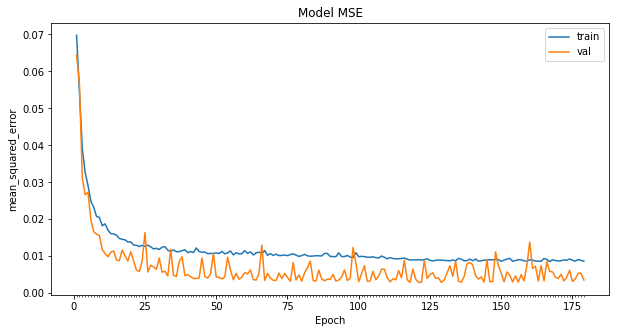

In [90]:
plot_model_history(hist, saveFig = False)

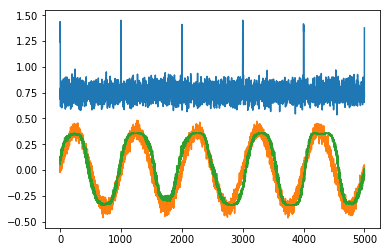

In [96]:
y_pred = model.predict(X_test)

plt.plot((X_test[:, 0]) + 1)
plt.plot((y_test))
plt.plot((y_pred))

In [92]:
X_train.shape

(18001, 1999)

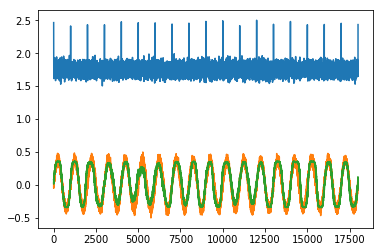

In [93]:
y_pred = model.predict(X_train)

plt.plot(X_train[:, 0] + 2)
plt.plot((y_train))
plt.plot((y_pred))

In [94]:
X_train.shape

(18001, 1999)

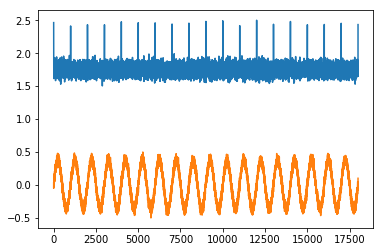

In [95]:
plt.plot(X_train[:, 0] + 2)
plt.plot(y_train[:, 0])

In [ ]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_shape=(None, layers[0]),
        units=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units = layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="adam", metrics = ['mse'])
    print("> Compilation Time : ", time.time() - start)
    return model

In [ ]:
model= build_model([1,50,100,1])
earlystop = EarlyStopping(monitor='val_mean_squared_error', min_delta=0.01, patience= 5, verbose=1, mode='auto')

In [ ]:
plt.plot(x_train[:, 499, 0])
plt.plot(y_train[:])

In [ ]:
model_info = model.fit(x_train, y_train, batch_size = 2**11, epochs=100, validation_split=0.05, callbacks = [earlystop])

In [ ]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history.history['mean_squared_error'])+1),model_history.history['mean_squared_error'])
    axs.plot(range(1,len(model_history.history['val_mean_squared_error'])+1),model_history.history['val_mean_squared_error'])
    axs.set_title('Model MSE')
    axs.set_ylabel('mean_squared_error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,len(model_history.history['val_mean_squared_error'])+1),len(model_history.history['val_mean_squared_error'])/10)
    axs.legend(['train', 'val'], loc='best')
    plt.show()

In [ ]:
plot_model_history(model_info)

In [ ]:
def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

In [ ]:
predicted = predict_point_by_point(model, x_test)
predicted.shape

In [ ]:
plt.figure(figsize = (10, 4))
x_test.shape
plt.plot(x_test[:, 499, 0], label = "input")
#plt.plot(y_test[], label = "output")
plt.plot(y_test[-x_test.shape[0]:] + 2, label = "y")
plt.plot(minmax_scale(predicted, feature_range=(-1,1)) + 2, label = "prediction")
plt.legend()

In [ ]:
pp = model.predict(x_test)

In [ ]:
plt.plot(y_test)

In [ ]:
plt.plot(pp)

In [ ]:


plt.figure(figsize = (20, 8))
plt.plot(comF.EMG_scaled[-len(predicted):].reset_index(drop = True)+ 2, label = "EMG")
plt.plot(comF.len_scaled[-len(predicted):].reset_index(drop = True), label = "actual")
plt.plot(minmax_scale(predicted, feature_range=(-1,1)), label = "predicted")
plt.legend()

In [ ]:
plt.figure(figsize = (20, 8))
plt.plot(comF.EMG_scaled[0:len(predicted)].reset_index(drop = True)+ 2, label = "EMG")
plt.plot(comF.len_scaled[0:len(predicted)].reset_index(drop = True), label = "actual")
#plt.plot(minmax_scale(predicted, feature_range=(-1,1)), label = "predicted")
plt.legend()

In [ ]:
x_test.shape

In [ ]:
predicted = predict_point_by_point(model, x_train[0:25000,:,:])
predicted.shape

In [ ]:

plt.figure(figsize = (20, 8))
plt.plot(x_train[0:25000, 999, 0])
plt.plot(minmax_scale(predicted, feature_range=(-1,1)), label = "predicted")
plt.legend()

In [ ]:
comF.EMG_scaled[0:len(predicted)].reset_index(drop = True)

In [ ]:
def reshape_dataTestONLY(sequence, ysequence, seq_len):
    sequence_length = seq_len + 1
    result = []
    for index in range(len(sequence) - sequence_length):
        result.append(sequence[index: index + sequence_length])
    result = np.array(result)
    
    result2 = []
    for index in range(len(ysequence) - sequence_length):
        result2.append(ysequence[index: index + sequence_length])
    result2 = np.array(result2)

    # shuffle windows
    #shuffInt = np.random.choice(np.arange(0, train.shape[1]), replace=False, size=train.shape[1])
#     train = train[:, shuffInt]
#     train2 = train2[:, shuffInt]
    #np.random.shuffle(train)

    x_test = result[:, :-1]
    y_test = result2[:, -1]

    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    
    
    return [x_test, y_test]

In [ ]:
timesteps = np.arange(0, 0.5, 1/25000 )

freq = 25

trainY1 = np.sin(2*np.pi*timesteps* freq) + np.random.normal(size=len(timesteps))*0.1
trainX1 =  np.cos(2*np.pi*timesteps * freq) * ((np.cos(2*np.pi*timesteps*freq)) > 0.99)*1 + np.random.normal(size=len(timesteps))*0.1
trainY1.shape

In [ ]:
plt.plot(minmax_scale(trainX1[0:12500], (-1,1)))
x_test2, _ = reshape_dataTestONLY(minmax_scale(trainX1[0:12500], (-1,1)), trainY1, 1000)
plt.show()
plt.plot(x_test2[:, 999, 0])

In [ ]:
predicted = predict_point_by_point(model, x_test2)
predicted.shape

In [ ]:
plt.figure(figsize = (20, 8))
plt.plot(x_test2[:, 999, 0], label = 'made-up EMG signal')
plt.plot(minmax_scale(predicted, feature_range=(-1,1)), label = "predicted")
plt.legend()

In [ ]:
propBreak = 0.9
windowLen = 200

backCt = int(len(trainX) - propBreak * len(trainX) + propBreak * windowLen)
print(backCt)

In [ ]:
plt.figure(figsize = (10,4))
plt.plot(trainY_scaled[-(backCt + 1):] + 2, label = "input data")
plt.plot(trainX_scaled[-(backCt-windowLen +1):], label = "data we're trying to predict")

plt.plot(x_test[:,0,0] + 2, label = "input data")
plt.plot(y_test[:], label = "ytest")
#plt.plot(yhat[-81:] -1, label = "smoothed")
plt.ylim([-2, 4])
plt.plot(predicted, label = 'predicted_LSTM')
plt.legend()
#plt.plot(y_test)
#plt.savefig(os.path.join(figDir, "LSTM_MadeUpData.png"), dpi = 500)


In [ ]:
plt.figure(figsize = (10,4))
plt.plot(trainY_scaled[-(backCt - windowLen +  1):] + 2, label = "input data")
plt.plot(trainX_scaled[-(backCt-windowLen +1):], label = "data we're trying to predict")

plt.plot(x_test[:,windowLen-1,0] + 2, label = "input data")
plt.plot(y_test[:], label = "ytest")

plt.ylim([-2, 4])
plt.plot(predicted, label = 'predicted_LSTM')
plt.legend()


In [ ]:
plt.plot(trainY_scaled[-(backCt + 1):] + 2, label = "input data")
plt.plot(trainX_scaled[(-backCt):], label = "data we're trying to predict")

In [ ]:
results = reshape_data(trainX, 50)

In [ ]:
np.random.shuffle(results)
results.shape

shuffInt = np.random.choice(np.arange(0, results.shape[1]), replace=False, size=results.shape[1])
results[:, shuffInt]

In [ ]:
shuffInt = np.random.choice(np.arange(0, result.shape[0]), replace=False, size=result.shape[0])
    train = train[:, shuffInt]